In [1]:
# do this if you use a custom virtual environment to specify the directory to look for installed packages
import sys
import os
## goes back to the project directory
os.chdir("..")
# switch to the name of your virtual environment
kernel_name = ".venv_mp"
sys.path.append("\\".join([os.getcwd(), kernel_name, "Lib\\site-packages"]))

In [2]:
import pandas as pd

In [3]:
methods = ["MMD", "MMD OCSVM Verify", "OCSVM"]
model_types = {"kernel=\'linear\'" : "linear", "SVR(":"non-linear", "LinearRegression" : "LReg"}
kernel_colors = {"linear" : "r", "non-linear" : "b", "LReg" : "o"}
colors = ["bo", "go", "ro", "co", "mo", "yo", "ko"]
direction_markers = [">", "<"]
marker_meaning = {">" : "forward", "<" : "backwards"}
normalized = {True : "-std", False: ""}
alpha_norm = {True : 1/3, False: 2/3}

In [35]:
data.loc[(data.experiment==2)&(data.method==methods[2])&(data.model_node=="pi2")]

,model_node,model,score,test_node,discrepancy,method,std,experiment,threshold
96,pi2,"SVR(C=100, epsilon=0.5)",0.749741,pi5,27.812873,OCSVM,False,2,0.85
100,pi2,"SVR(C=100, epsilon=1, kernel='linear')",0.748539,pi5,28.268915,OCSVM,False,2,0.85
104,pi2,LinearRegression(),0.749143,pi5,28.145389,OCSVM,False,2,0.85
108,pi2,SVR(C=100),0.768587,pi5,28.697031,OCSVM,True,2,0.85
112,pi2,"SVR(C=0.1, epsilon=0.2, kernel='linear')",0.741892,pi5,28.978725,OCSVM,True,2,0.85
116,pi2,LinearRegression(),0.749143,pi5,28.145380,OCSVM,True,2,0.85
120,pi2,"SVR(C=100, epsilon=0.5)",0.749741,pi4,0.606816,OCSVM,False,2,0.75
124,pi2,"SVR(C=100, epsilon=1, kernel='linear')",0.748539,pi4,0.985362,OCSVM,False,2,0.75
128,pi2,LinearRegression(),0.749143,pi4,0.962362,OCSVM,False,2,0.75
132,pi2,SVR(C=100),0.768587,pi4,1.512463,OCSVM,True,2,0.75


In [14]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

def plot_r2_discrpenacy(data):
    for experiment in range(1,4):
        for method_index in range(3):
            df = data.loc[(data.experiment==experiment)&(data.method==methods[method_index])]
            n_pairs =  int(df.shape[0]/(2*3*2))

            fig, axs = plt.subplots(nrows = n_pairs, ncols = 1, 
                                    sharex="row", sharey='row',
                                    figsize= (5 ,4  * n_pairs))

            df_similar_pairs = pd.DataFrame.from_records(np.unique(df[["model_node", "test_node"]].to_records(index=False)))     

            for pair_index in range(n_pairs):
                pair = df_similar_pairs.iloc[pair_index*2].copy()
                backwards_pair =  df_similar_pairs.loc[(df_similar_pairs.test_node == pair.model_node) & 
                                        (df_similar_pairs.model_node == pair.test_node)]
                    
                if pair_index*2+1 != backwards_pair.index:
                    misplaced_pair = df_similar_pairs.loc[pair_index*2+1]
                    df_similar_pairs.iloc[backwards_pair.index] = misplaced_pair
                    df_similar_pairs.iloc[pair_index*2+1] = backwards_pair
                
                if pair.model_node > pair.test_node:
                    df_similar_pairs.iloc[pair_index*2] = backwards_pair
                    df_similar_pairs.iloc[pair_index*2+1] = pair
                    
            similar_pairs = [str((pair[0], pair[1])) for pair in df_similar_pairs.values]
            
            for row in df.itertuples(index=True, name='Pandas'):
                model_type = [model_types[m] for m in model_types if m in row.model][0]
                if model_type  in ["linear", "non-linear"]:
                    pair = str((row.model_node, row.test_node))
                    label = "".join([model_type, normalized[row.std]])

                    pair_index = similar_pairs.index(pair)
                    direction = pair_index % 2

                    color = kernel_colors[model_type]
                    x, y = row.discrepancy, row.score

                    pair_row = int((pair_index - direction)/2)
                    args = [color, label, alpha_norm[row.std], direction_markers[direction]]

                    if n_pairs == 1:
                        axs.plot(x, y, args[0], label = args[1], alpha = args[2], marker = args[3])
                    else:
                        axs[pair_row].plot(x, y, args[0], label = args[1], alpha = args[2], marker = args[3])

            fig.suptitle(methods[method_index], fontsize =15)
            fig.tight_layout(pad=3.0)

            if n_pairs==1:
                axs.set_title(similar_pairs[0], fontsize=10)
                axs.set_xlabel("Discrepancy")
                axs.set_ylabel("Coefficient of Determination")
            else:
                for r in range(n_pairs):
                    axs[r].set_title(similar_pairs[r*2], fontsize=10)
                    axs[r].set_xlabel("Discrepancy")
                    axs[r].set_ylabel("Coefficient of Determination")

            d = df[["model_node", "test_node"]].values
            x = d[:,0]
            y = d[:,1]
            kernel_lines = [Line2D(x, y, c= kernel_colors[k], alpha = 2/3, linewidth=5) for k in ["linear","non-linear"]]
            std_lines = [Line2D(x, y, c= "r", alpha = alpha_norm[True], linewidth = 5)]
            direction_lines = [Line2D(x, y, c= "b", alpha = 2/3, marker = marker, linewidth = 0) for marker in direction_markers]

            lines = kernel_lines + std_lines + direction_lines

            plt.legend(lines, ["linear", "non-linear", "std", "forward", "backwards"])
            plt.show()

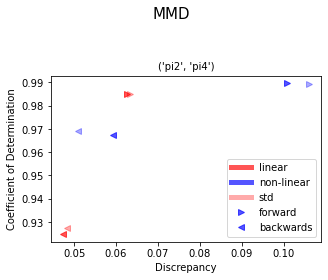

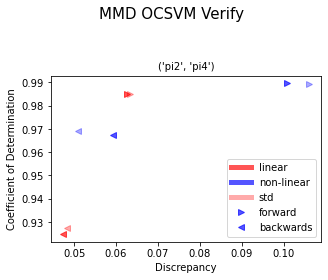

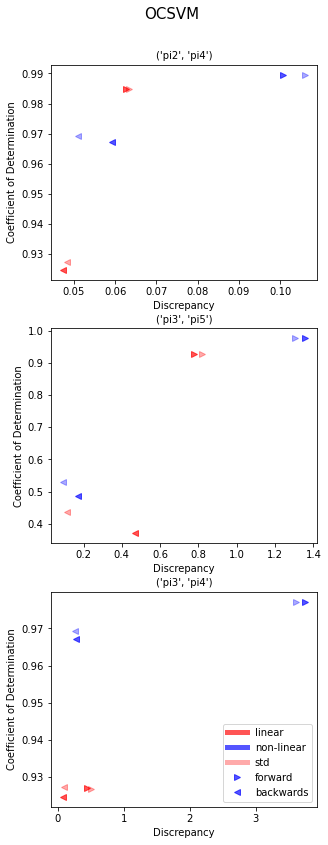

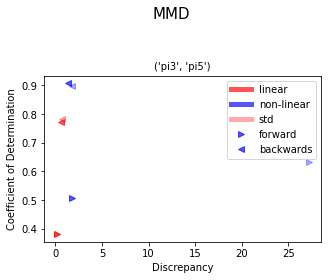

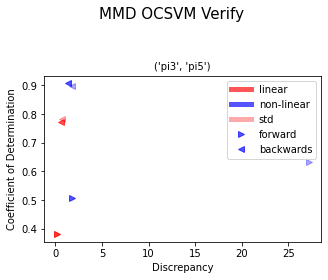

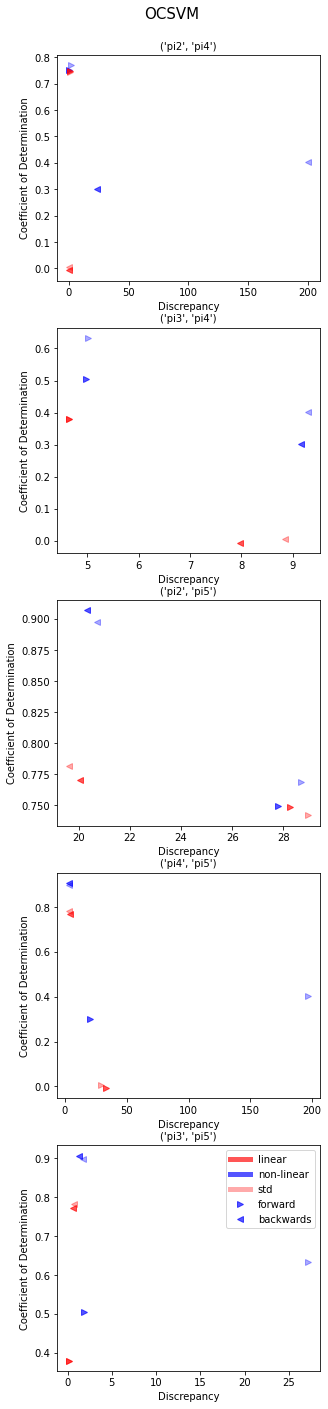

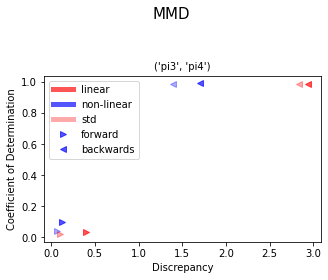

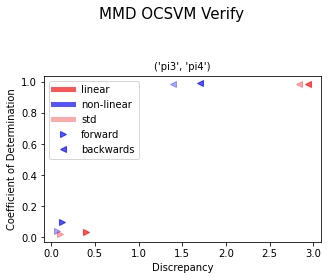

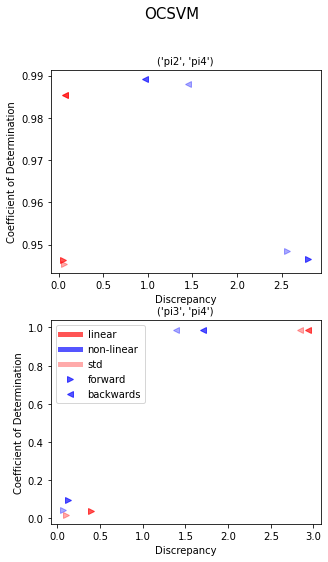

In [16]:
for i in range(1):
    data = pd.read_csv(f"results/per method/sample_{i+1}.csv") 
    plot_r2_discrpenacy(data)

In [120]:
data.loc[(data.experiment==3)&(data.method==methods[0])]

,model_node,model,score,test_node,discrepancy,method,std,experiment,threshold
144,pi3,"SVR(C=0.1, epsilon=0.2)",0.097421,pi4,1.025609,MMD,False,3,-
145,pi4,"SVR(C=100, epsilon=0.2)",0.989195,pi3,0.987709,MMD,False,3,-
146,pi3,SVR(kernel='linear'),0.017552,pi4,0.771346,MMD,False,3,-
147,pi4,"SVR(C=100, epsilon=0.01, kernel='linear')",0.985545,pi3,1.678790,MMD,False,3,-
148,pi3,LinearRegression(normalize=True),0.020976,pi4,0.668197,MMD,False,3,-
149,pi4,LinearRegression(normalize=True),0.985620,pi3,1.812777,MMD,False,3,-
150,pi3,"SVR(C=0.001, epsilon=0.01)",0.043498,pi4,1.023734,MMD,True,3,-
151,pi4,SVR(C=10),0.989063,pi3,0.600929,MMD,True,3,-
152,pi3,"SVR(C=0.01, epsilon=0, kernel='linear')",-0.000743,pi4,1.013639,MMD,True,3,-
153,pi4,"SVR(C=100, epsilon=0.01, kernel='linear')",0.985591,pi3,1.831129,MMD,True,3,-


In [124]:
data.loc[(data.experiment==3)&(data.method==methods[2])]

,model_node,model,score,test_node,discrepancy,method,std,experiment,threshold
156,pi2,"SVR(C=1, epsilon=0.2)",0.943940,pi4,2.665538,OCSVM,False,3,0.45
157,pi4,"SVR(C=100, epsilon=0.2)",0.989195,pi2,0.513938,OCSVM,False,3,0.45
158,pi4,"SVR(C=100, epsilon=0.2)",0.989195,pi3,0.987709,OCSVM,False,3,0.45
159,pi3,"SVR(C=0.1, epsilon=0.2)",0.097421,pi4,1.025609,OCSVM,False,3,0.45
160,pi2,SVR(kernel='linear'),0.941218,pi4,0.060194,OCSVM,False,3,0.45
161,pi4,"SVR(C=100, epsilon=0.01, kernel='linear')",0.985545,pi2,0.041031,OCSVM,False,3,0.45
162,pi4,"SVR(C=100, epsilon=0.01, kernel='linear')",0.985545,pi3,1.678790,OCSVM,False,3,0.45
163,pi3,SVR(kernel='linear'),0.017552,pi4,0.771346,OCSVM,False,3,0.45
164,pi2,LinearRegression(),0.941618,pi4,0.065959,OCSVM,False,3,0.45
165,pi4,LinearRegression(normalize=True),0.985620,pi2,0.031268,OCSVM,False,3,0.45
